# Deep Dive `II`

Today we are going to take a deep dive into **regression**.

In this session our aims are:
1. Experience the joys of data cleaning,
1. Try our hand at feature selection and feature engineering,
1. Use KNN to generate continuous output (regression)
1. Use a linear regression model and compare it to our KNN
1. Use PCA to reduce the dimensionality of our data

Each of the above will be done with the goal of being able to predict the redshift of galaxies for which we don't have spectral observations - photometric redshift determination.

## tinyurl.com/ASADeepDive2023

^ Head to this link to access the course materials

Open the file "Deep Dive I - Challenges"

Select File -> "Save a copy in Drive"
(login to google and approve the "colaboratory" app if asked)

## Setting up our session
This is a new notebook so we need to update pandas and import all our modules again

In [ ]:
! pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 32.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.


In [ ]:
# data reading and manipulation libraries
import numpy as np
import pandas as pd
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning tools
import sklearn
from sklearn import (metrics, model_selection, feature_selection,
                     preprocessing, naive_bayes, linear_model)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
print(f"Numpy:        {np.__version__}")
print(f"Pandas:       {pd.__version__} <- ensure this is 2.0 or higher")
print(f"Matplotlib:   {matplotlib.__version__}")
print(f"Seaborn:      {sns.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

Numpy:        1.22.4
Pandas:       2.0.3 <- ensure this is 2.0 or higher
Matplotlib:   3.7.1
Seaborn:      0.12.2
Scikit-learn: 1.2.2


## 1. Data cleaning



We are going to be using a larger data set this time, and one which has only galaxies in it.
You can download and view the data set from this [link](https://raw.githubusercontent.com/PaulHancock/2023-ASA-ML-DeepDive/main/SDSS_10k_Galaxy.csv).
We'll download it directly to our colaboratory using `wget` as we did in the previous deep dive.

In [ ]:
! wget https://raw.githubusercontent.com/PaulHancock/2023-ASA-ML-DeepDive/main/SDSS_10k_Galaxy.csv

--2023-07-06 22:37:30--  https://raw.githubusercontent.com/PaulHancock/2023-ASA-ML-DeepDive/main/SDSS_10k_Galaxy.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1719644 (1.6M) [text/plain]
Saving to: ‘SDSS_10k_Galaxy.csv’

SDSS_10k_Galaxy.csv 100%[===================>]   1.64M  --.-KB/s    in 0.01s   

2023-07-06 22:37:30 (172 MB/s) - ‘SDSS_10k_Galaxy.csv’ saved [1719644/1719644]



![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Now load the data set and inspect it quickly to see what we are dealing with.

In [ ]:
galaxy_df = pd.read_csv('SDSS_10k_Galaxy.csv')

In [ ]:
# how many rows/columns?
galaxy_df.shape

(10000, 22)

In [ ]:
# get a summary of the dataset
galaxy_df

,objid,ra,dec,u,g,r,i,z,run,rerun,...,specobjid,class,redshift,plate,mjd,fiberid,SpType,BV,TEff,FeH
0,1237655348351730428,230.088751,53.530246,25.89612,22.78891,20.71988,19.58575,19.16193,2299,301,...,7559433644827498496,GALAXY,0.567759,6714,56447,515,NaN,0,0,0
1,1237655348351795637,230.150417,53.334604,22.50740,22.30737,20.68399,19.62643,19.27208,2299,301,...,7559434194583312384,GALAXY,0.554449,6714,56447,517,NaN,0,0,0
2,1237655348351861356,230.580283,53.306956,25.40687,22.20122,20.70762,19.77221,19.06285,2299,301,...,7559440241897265152,GALAXY,0.565015,6714,56447,539,NaN,0,0,0
3,1237655348888535525,230.462073,53.957891,22.89358,20.78360,19.10300,18.48347,18.05243,2299,301,...,7559444365065869312,GALAXY,0.335591,6714,56447,554,NaN,0,0,0
4,1237655348888601055,230.432304,53.742019,25.83605,21.92424,20.42663,19.60208,18.99489,2299,301,...,7559433095071684608,GALAXY,0.478235,6714,56447,513,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1237664836472078855,147.337542,31.317853,23.60569,21.81948,20.41451,19.38909,19.04709,4508,301,...,6531560145406941184,GALAXY,0.649309,5801,56328,781,NaN,0,0,0
9996,1237664836472078810,147.303004,31.369126,22.51074,22.02617,21.09144,19.96449,19.54834,4508,301,...,6531549150290663424,GALAXY,0.764803,5801,56328,741,NaN,0,0,0
9997,1237664835935142344,147.374929,30.905672,24.81575,22.83498,20.82496,19.75174,19.34924,4508,301,...,6531562344430196736,GALAXY,0.528492,5801,56328,789,NaN,0,0,0
9998,1237664835935142262,147.361744,30.850190,25.00649,22.18135,20.63359,19.63124,19.13552,4508,301,...,6531562894186010624,GALAXY,0.600479,5801,56328,791,NaN,0,0,0


In [ ]:
galaxy_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,...,field,specobjid,redshift,plate,mjd,fiberid,SpType,BV,TEff,FeH
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.0,...,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.00000,0.0,10000.0,10000.0,10000.0
mean,1.237665e+18,163.366791,20.965777,22.397440,20.805410,19.529200,18.802429,18.388960,4447.77040,301.0,...,183.284700,5.865334e+18,0.417744,5209.366200,55489.251200,396.79450,NaN,0.0,0.0,0.0
std,7.985401e+12,74.752272,16.115423,2.329123,2.270056,2.010137,1.798883,1.743834,1859.25356,0.0,...,122.821667,3.852823e+18,0.284065,3421.976387,2038.451799,258.60008,NaN,0.0,0.0,0.0
min,1.237646e+18,0.202136,-9.409396,15.028880,13.857590,12.946620,12.395470,12.149890,94.00000,301.0,...,11.000000,2.995158e+17,-0.007743,266.000000,51630.000000,1.00000,NaN,0.0,0.0,0.0
25%,1.237658e+18,132.405403,6.082047,20.340373,18.557555,17.638993,17.214298,16.922108,2964.00000,301.0,...,100.000000,2.374583e+18,0.132859,2109.000000,53795.000000,166.75000,NaN,0.0,0.0,0.0
50%,1.237665e+18,153.811026,17.818288,22.726710,21.487835,20.032355,19.135210,18.680125,4508.00000,301.0,...,163.000000,5.837843e+18,0.438956,5185.000000,55978.000000,381.00000,NaN,0.0,0.0,0.0
75%,1.237668e+18,218.183065,32.970094,24.113957,22.528742,21.220797,20.169052,19.585217,5314.00000,301.0,...,238.000000,8.596317e+18,0.616611,7635.000000,56979.000000,565.00000,NaN,0.0,0.0,0.0
max,1.237681e+18,359.678397,64.764792,28.017250,27.006480,30.697160,27.923300,26.649440,8162.00000,301.0,...,825.000000,1.412463e+19,1.972819,12545.000000,58932.000000,1000.00000,NaN,0.0,0.0,0.0


### Data scale

Note that the columns have a different mean, std, and min/max.
Also note that some of the columns are either empty (all `NaN`) or information free (constant values).

The regression algorithims that we will use today are distance based methods, which means that they are sensitive to differences in the scale of our features.
For example, we have $α ∈ (-10, +65)$, the $\textrm{objid} ∈ (1e+18,2e+18)$, and $\textrm{redshift} ∈ (-0.001, 2)$.
A "distance" of 1 in each of these dimensions is not equally relevant.

If we plot a histogram for each feature we can see the different scales an distributions of the data.

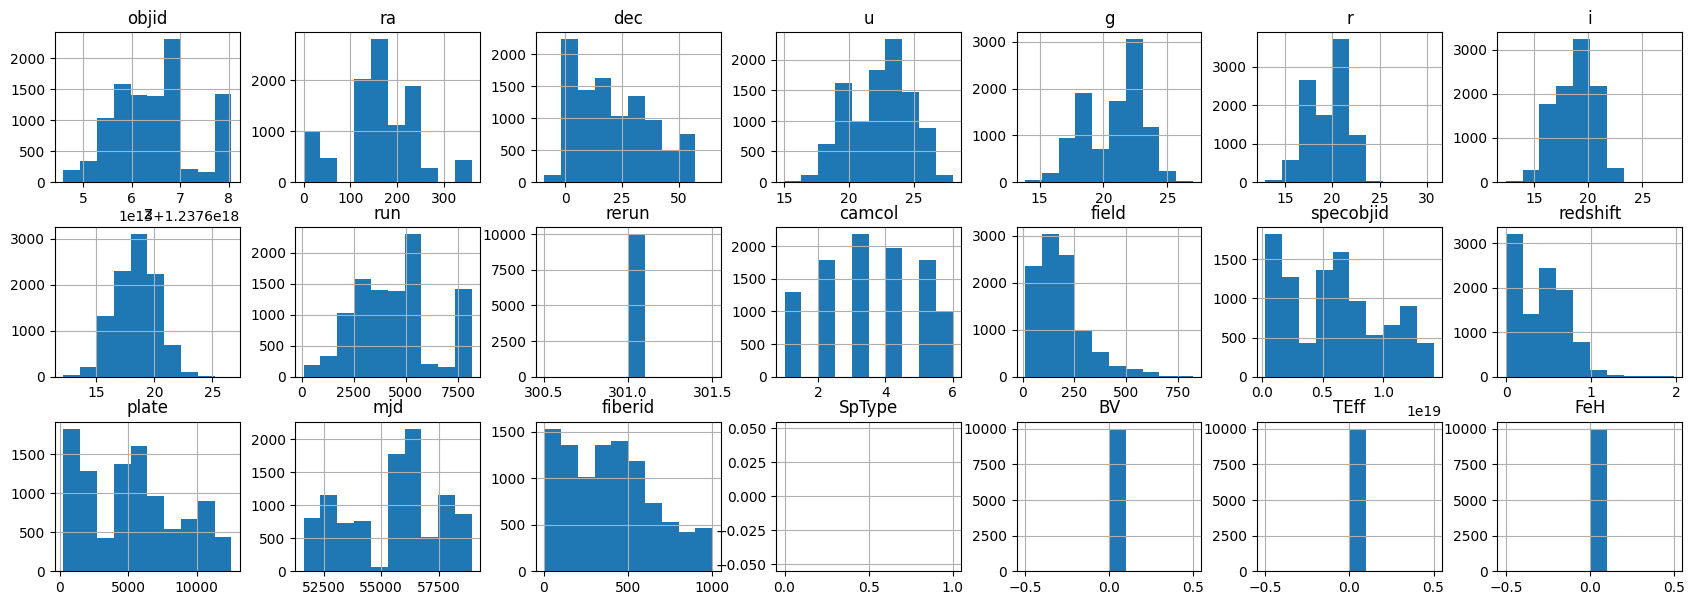

In [ ]:
# setup a grid of axes ahead of time, otherwise pandas tries to put these all on the same plot
fig, ax = plt.subplots(3,7, figsize=(21, 7))
galaxy_df.hist(grid=True, ax=ax)
plt.show()

In order to eliminate issues with scaling we will transform all our numeric features using a min/max scaler.
Some of the features look like they may have a normal or power-law distribution, so min/max might not be the best solution, but this is what we'll go with for now.
You can come back and try different scalers at a later time.

The preprocessing classes have a similar interface to the ML models:
- `.fit` to fit the transformer to your data
- `.transform` to return the transformed data
- `.fit_transform` to do both at once

In [ ]:
# Select just the numeric data, copy it because we will modify it
numerics = galaxy_df.select_dtypes(include=np.number)
# create a minmax scaler
minmax = preprocessing.MinMaxScaler()
# "fit" the scaler -> determine the min/max for each column
minmax.fit(numerics)

# Transform the data and save it back to our dataframe
numerics[:] = minmax.transform(numerics)
#        ^ this slicing hack causes the values of the pandas dataframe to
# be overwritten with the values from a numpy array (from the tranform)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Look at our scaled data to check the effects of our code.

You should see all columns have a $min = 0$ and $max = 1.0$ (except for columns which had constant values).

In [ ]:
# describe the data again
numerics['field'].describe()

count    10000.000000
mean         0.211652
std          0.150887
min          0.000000
25%          0.109337
50%          0.186732
75%          0.278870
max          1.000000
Name: field, dtype: float64

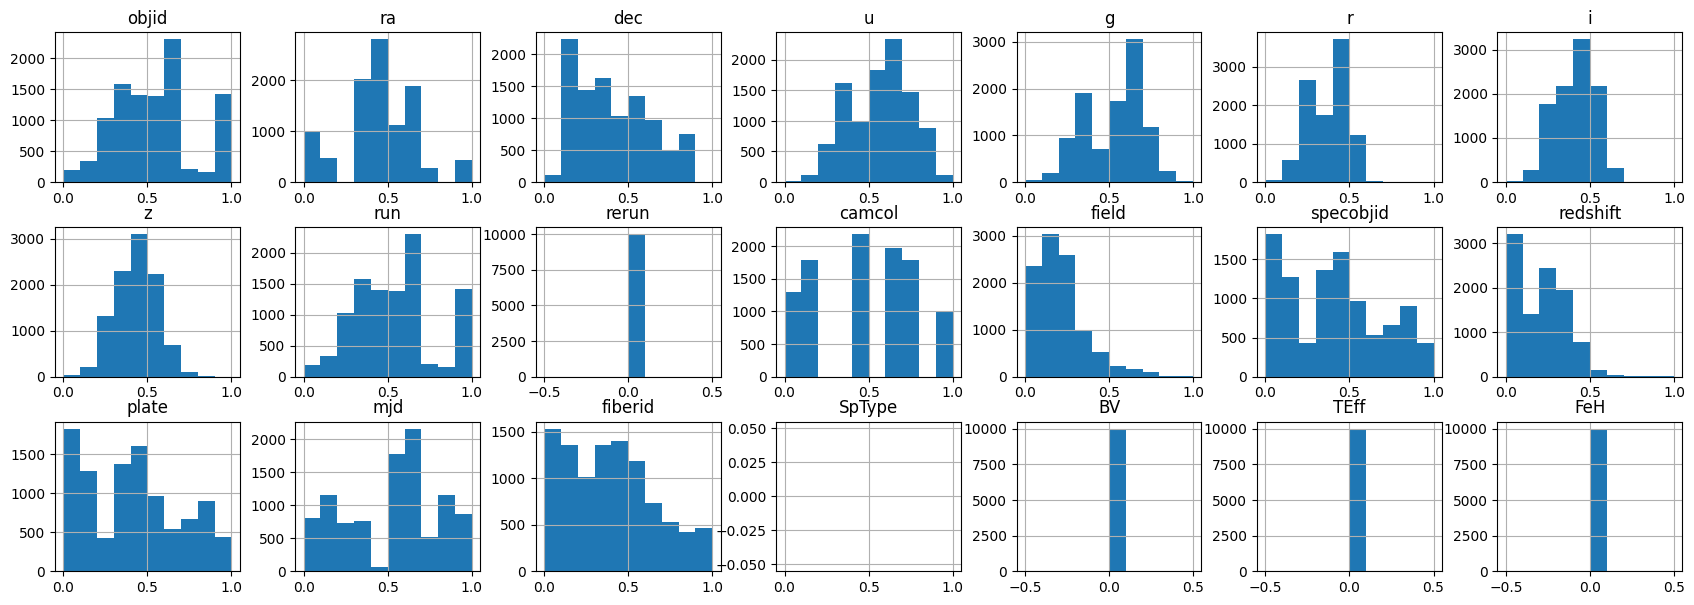

In [ ]:
# redo the plot
fig, ax = plt.subplots(3,7, figsize=(21, 7))
numerics.hist(grid=True, ax=ax)
plt.show()

A more compact way to visualise the spread of data within our range $[0,1]$ is to use a box and whisker plot.

Seaborn gives us a fairly nice way to do this, we just have to make sure that we fiddle the axis labels so they don't overlap.

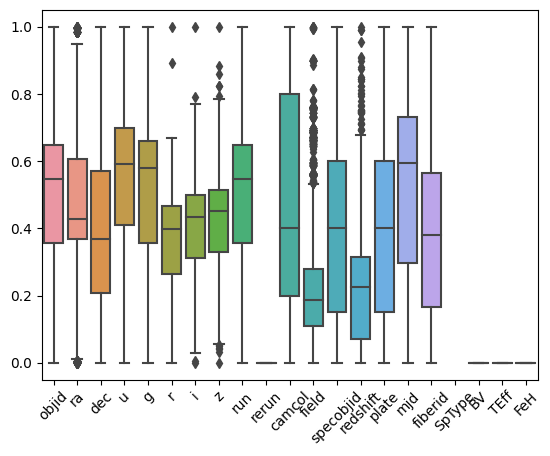

In [ ]:
ax = sns.boxplot(numerics)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

Look for missing data (rows/columns)

Most ML models don't know what to do with missing values, and with either complain or (worse) silently give bad results.

If we find missing data then we should consider the following actions:
- remeasure the value
- impute a value (compute using the rest of the data)
- delete the row with missing data
- delete the column with missing data

In [ ]:
#        |--> ask if any of the values are nul/nan, returns a new data frame of true/false
numerics.isna().any()
#              |--> ask if any of the columns contain a true value

objid        False
ra           False
dec          False
u            False
g            False
r            False
i            False
z            False
run          False
rerun        False
camcol       False
field        False
specobjid    False
redshift     False
plate        False
mjd          False
fiberid      False
SpType        True
BV           False
TEff         False
FeH          False
dtype: bool

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

From the above it looks like the only column with missing data is 'SpType' which is filled with `NaN` values.
We should drop this column.

Use the `.drop()` function to drop the column 'SpType'

In [ ]:
numerics = numerics.drop(columns='SpType')

In [ ]:
numerics.shape

(10000, 20)

Dupilcate data is a little more insiduous in it's effect on our ML models.
Effectively a duplicated entry is a way of giving more weight to that entry when a model is being trained.
In some cases this is done intentionally to amplify rare data points, but usually we want to exclude duplicates.
At any rate we should at least check to see how many entries have been duplicated.

In [ ]:
# check to see if any rows are duplicates of other rows
#        |-----> search for duplicates, returns list of true/false
numerics.duplicated().any()
#                     |----> return true if any in the list are true

False

We should also look for duplicate columns, however we'll address that during the feature selection stage.

So far we have focused on the numerical attributes of our data rather than the categorical (string) attributes.
For this particular data set there are two categorical features: 'class' and 'SpType' which are either empty or contain only a single value.
Both of these would be removed.

In the case that we were interested in using one of these features for our ML goals, we should look for missing/duplicated/incorrect values and adjust accordingly.
While it is possible to work with categorical data for many ML algorithms, `scikit-learn` can't do this directly, and will instead require you to encode your categorical data as numerical data.

## 2. Feature selection

We now want to start removing features that we don't think are useful.
By "useful" we mean that they could help with our regression task, which in this case is predicting the redshifts.

There are a few ways to do this:
1. If you have domain knowledge then you can elliminate features *a priori* (eg. objid should be unrelated to any physical features of a galaxy)
1. You can remove features with low variance. The assumption being that low variance means that the feature is unlikely to have much predictive power. (lower variance means more likely to be constant).
1. You can look at how well each feature correlates with the target (redshift) and keep only features with high correlation. This assumes a linear realationship between features (but then so do many ML models!)
1. You can recursively apply a ML model to different subsets of features and see how well they can predict the target and then eliminate those that do the worst.

As astronomers, we would expect that only the features $(u, g, r, i, z)$ will be usful in predicting the redshift as they are GALAXY properties rather than meta-data associated with the observing. By that logic $(α,δ)$ should also be included, but if the universe is isotropic then we shouldn't see any dependence between sky position and redshift (at least on large scales).

For now, lets leave all the "non-astro" features in, and move to option (2).

`scikit-learn` gives us a `VarianceThreshold` feature selection tool, which operates on just the input features $(X)$.

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Choose a variance threshold of 0.01 ($\sim σ=0.1$) and see which features are eliminated.

In [ ]:
# Create our X vector to exclude the target column
X = numerics.drop(columns='redshift')


In [ ]:
# remove features that have a low variance
vt = feature_selection.VarianceThreshold(threshold=0.01)
# 'fit' the selector
vt.fit(X)
# Get the features
vt_selected = vt.get_feature_names_out()

print("Eliminated:", [ a for a in X.columns if a not in vt_selected])

Eliminated: ['rerun', 'BV', 'TEff', 'FeH']


As expected the constant features (with no variance) were eliminated, but all others remained.

Moving on to option (3), we'll look at correlations between the data $(X)$ and our target feature $(y)$.

The selection tool `SelectKBest` allows us to choose the K best features from a data set using a selection statistic of our choosing.

Lets use the `mutual_info_regression` statistic from the `feature_selection` module, and choose the 8 best features.
The "mutual information" statistic is essentially a meaures of how well you can use one feature to predict the value of the other, it's like a correlation co-efficient but without assuming a linear relation.

Below we define a wrapper function that does the feature selection and then displays a summary.

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Execute the cell so that our function is loaded

In [ ]:
def kb_features(X,y,k):
  """
  Select the k best features based on the mutual information metric

  parameters
  ----------
  X : pandas.DataFrame
    Features for prediction

  y : pandas.DataFrame
    Target features that will be predicted

  k : int
    The number of best features to keep

  returns
  -------
  selected : list
    A list of the k best features that were selected. The ordering
    matches the ordering within the data set X, not the order of 'best-ness'
  """

  # create a feature selection model
  kb = feature_selection.SelectKBest(feature_selection.mutual_info_regression, k=k)

  # fit the model and get the selected features
  kb.fit(X,y)
  kb_selected = kb.get_feature_names_out()

  # make some summary output
  for feature,score in zip(X.columns, kb.scores_):
    print(f"{feature:9s} = {score:5.3f}", end='')
    if feature in kb_selected:
      print(" <- selected")
    else:
      print()

  # return the selected features
  return kb_selected


![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Start with X including the features selected by our variance tranformer and y being the redshifts.

Apply our `kb_features` selector function and report on the 8 best features.

In [ ]:
# update by removing not selected features
#  or by choosing the selected features
X = numerics[vt_selected]
# remove features using our a-priori knowledge
# X = ?
# create our target column
y = numerics['redshift']
# and now select the best features
selected_features = kb_features(X,y,8)

print(f"Selected features: {selected_features}")

objid     = 0.588
ra        = 0.858 <- selected
dec       = 0.626
u         = 0.666
g         = 0.977 <- selected
r         = 1.012 <- selected
i         = 0.944 <- selected
z         = 0.861 <- selected
run       = 0.589
camcol    = 0.039
field     = 0.397
specobjid = 0.971 <- selected
plate     = 0.972 <- selected
mjd       = 0.999 <- selected
fiberid   = 0.176
Selected features: ['ra' 'g' 'r' 'i' 'z' 'specobjid' 'plate' 'mjd']


![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

What do you notice about the features being selected?

What does it mean when a feature like 'plate' is slected with a score that is higher than $u$?

Uncomment the line which drops the specobjid, plate, and mjd features and rerun the above cell.

What difference does it make to drop these features?

For a full view of the correlation of all parameters we can use the pandas `.corr()` method to compute the correlation and then the seaborn `.heatmap()` method to display it.

We should expect similar results to the above, but remember that correlation and mutual information are not the same, just similar.

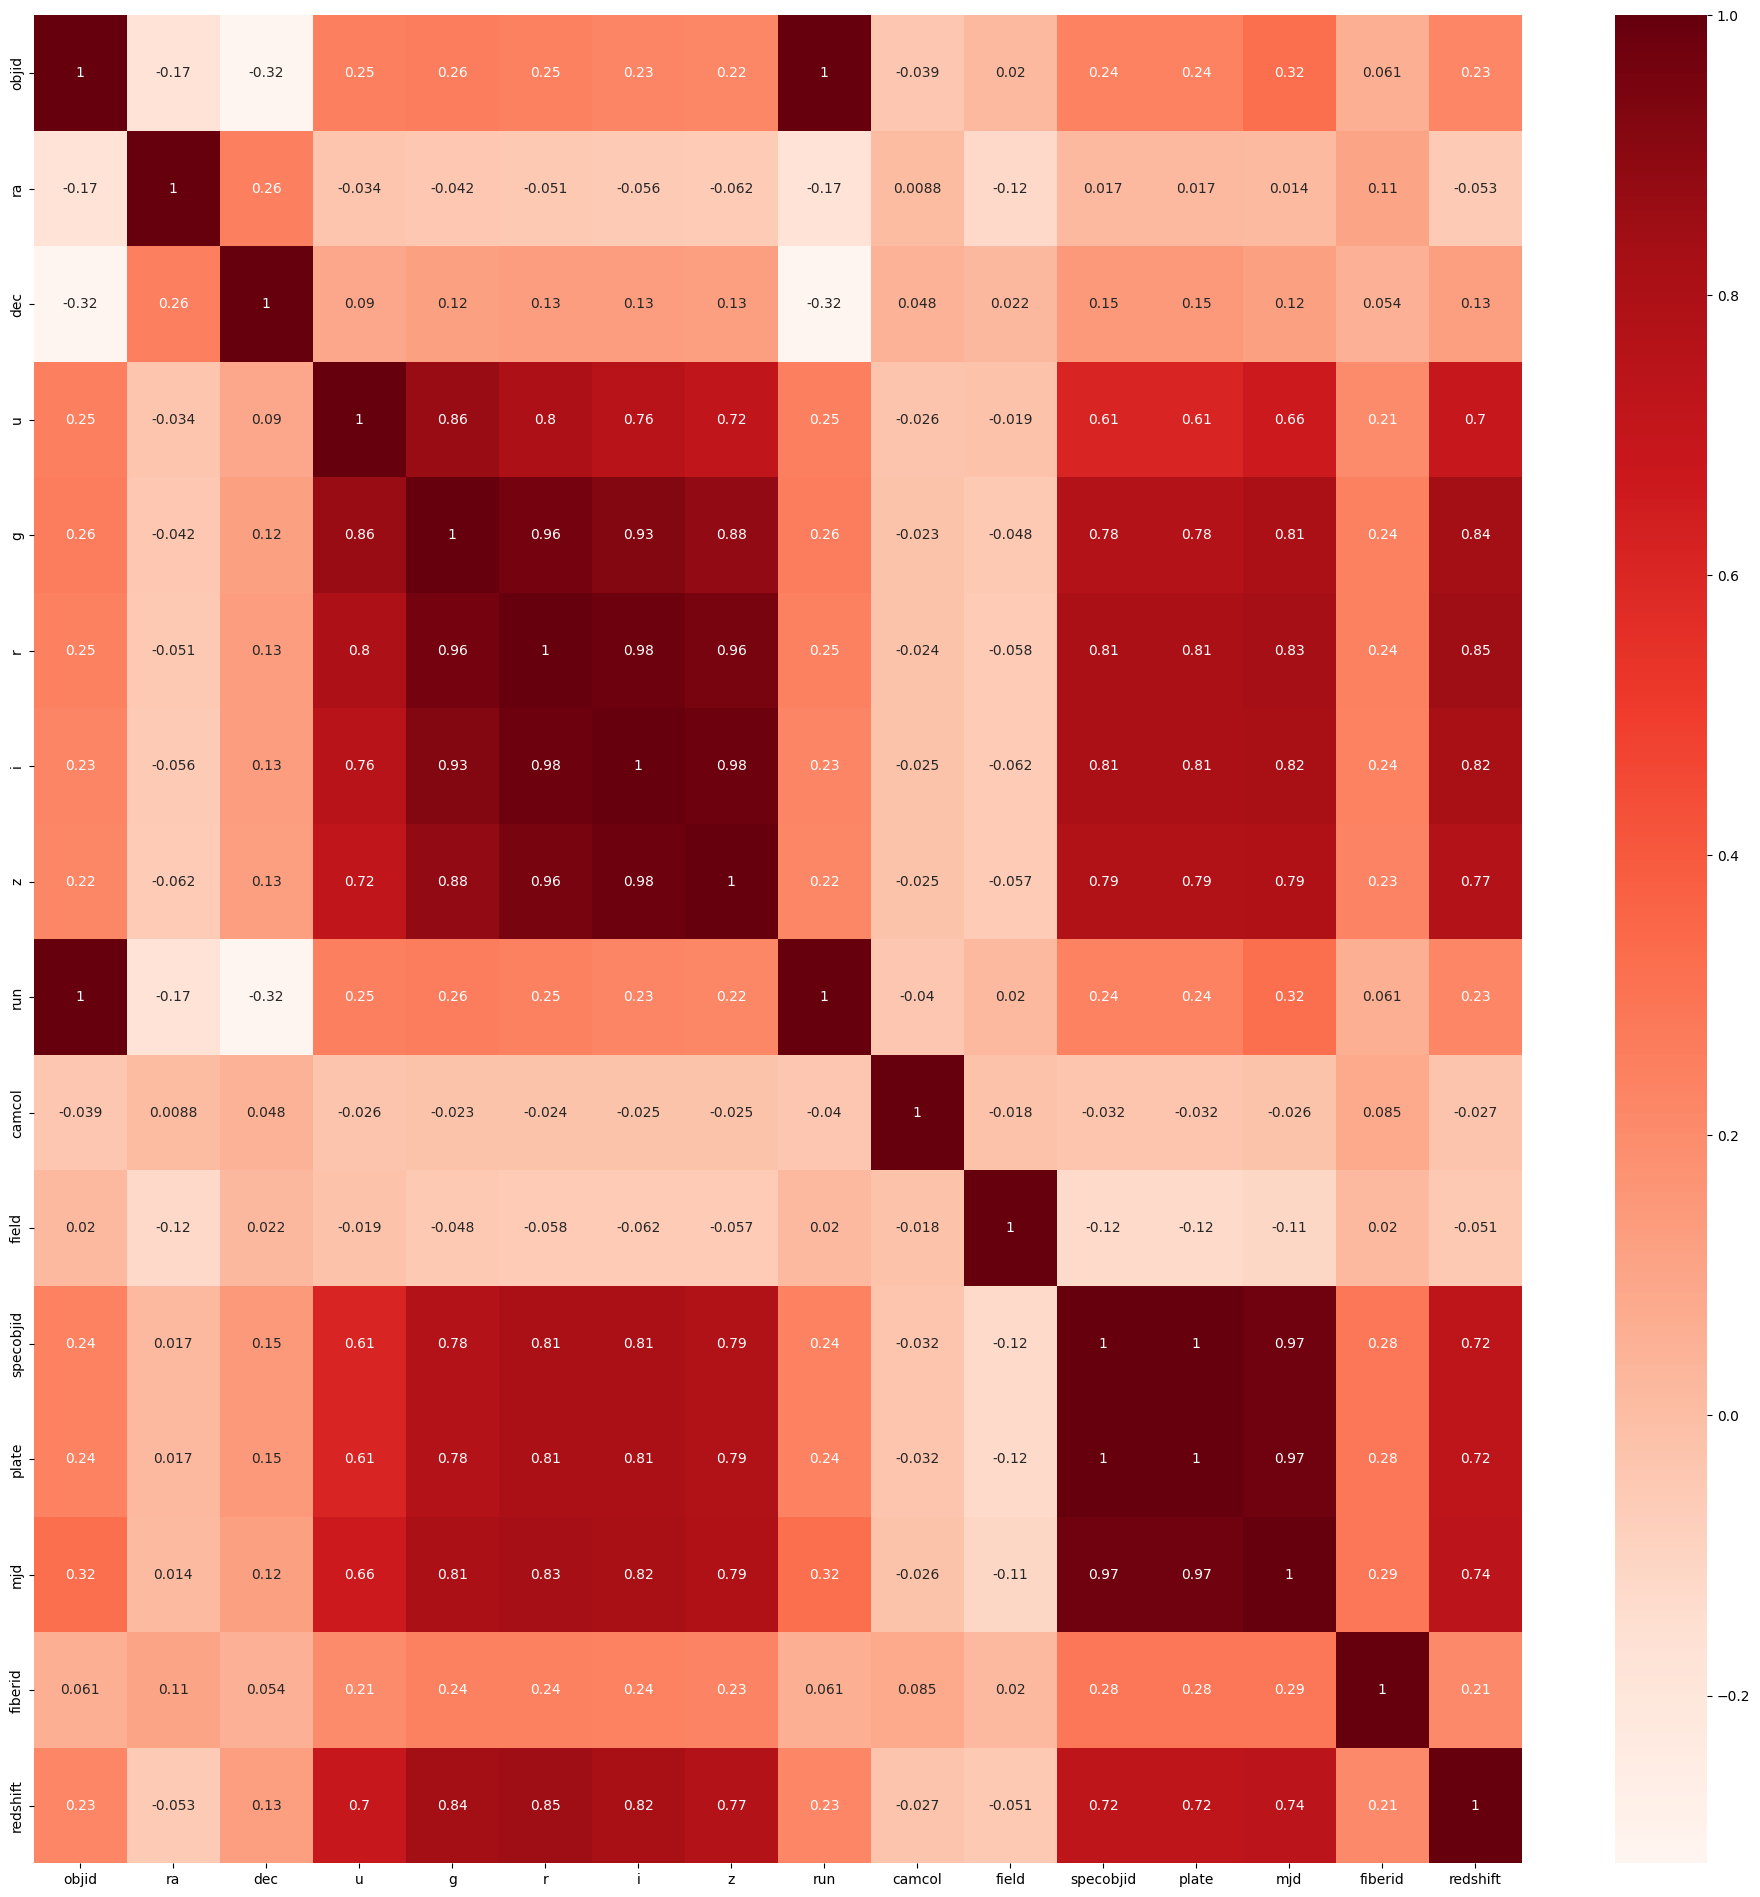

In [ ]:
# Compute the correlation between each of the numeric parameters as well as the
# target attribute
cor = numerics[vt_selected].join(y).corr()

# use seaborn to do the plot
fig, ax = plt.subplots(1,1, figsize=(24,24))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, ax=ax)
plt.show()

Looking at the correlation map above we can see examples of:
- attribtes which have a correlation of ~1,
- attributes which are highly correlated with the redshift,
- attributes which have very low correlation with the redshift.

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

In each of the above cases, how does this inform our feature selection?

Why does 'specobjid' correlate so well with 'plate'?

Notice that despite our prior assumptions, there really is a relation between redshift and 'specobjid', 'plate', and 'mjd'. How could this be the case?


![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Is correlation the best way to judge the utility of a feature?

What assumptions are we making here?

How could we make different assumptions?

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Take the kbest features from above and assign them to $X$ for further work.

In [ ]:
X = numerics[selected_features].copy()

## 3. Feature engineering

So far we have focused on selecting existing features for our modeling, however we are also able to generate new features from existing ones.
A classic example of this in astronomy is taking the difference between magnitudes in different bands and calling them "colours".

Let us see the effect of this feature engineering on our data.


![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Use the un-scaled data to create colours like $u-g$ and add these features to our data frame.

In [ ]:
# Create colours as our new features using the *RAW* values
X['u-g'] = galaxy_df['u'] - galaxy_df['g']
X['g-r'] = galaxy_df['g'] - galaxy_df['r']
X['r-i'] = galaxy_df['r'] - galaxy_df['i']
X['i-z'] = galaxy_df['i'] - galaxy_df['z']

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Now that you have the new features we should also scale them to the same range as the other data.

Finaly, make a copy of the feature engineered data.

In [ ]:
# Once computed we can scale the new features so that they also have a range of [0,1]
X[ ['u-g','g-r','r-i','i-z'] ] = minmax.fit_transform(X[ ['u-g','g-r','r-i','i-z'] ])
X_fe = X.copy()
X_fe.describe()

,ra,g,r,i,z,specobjid,plate,mjd,u-g,g-r,r-i,i-z
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.453895,0.528396,0.370838,0.412611,0.430294,0.402587,0.402587,0.528520,0.453678,0.614639,0.568014,0.577812
std,0.207948,0.172642,0.113244,0.115849,0.120268,0.278683,0.278685,0.279163,0.084515,0.030157,0.020030,0.030171
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.367766,0.357442,0.264351,0.310335,0.329129,0.150094,0.150094,0.296494,0.406550,0.594144,0.554162,0.568462
50%,0.427313,0.580296,0.399184,0.434043,0.450375,0.400599,0.400603,0.595453,0.453015,0.616244,0.565033,0.575324
75%,0.606385,0.659459,0.466137,0.500623,0.512797,0.600125,0.600130,0.732539,0.490950,0.634460,0.582012,0.587583
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Check if these new features are actually useful by using our `SelectKBest` again.

In [ ]:
fe_selected_features = kb_features(X_fe,y,8)
print(f"Selected features: {fe_selected_features}")

ra        = 0.857
g         = 0.977 <- selected
r         = 1.012 <- selected
i         = 0.944 <- selected
z         = 0.861 <- selected
specobjid = 0.971 <- selected
plate     = 0.972 <- selected
mjd       = 0.998 <- selected
u-g       = 0.324
g-r       = 0.666
r-i       = 0.986 <- selected
i-z       = 0.470
Selected features: ['g' 'r' 'i' 'z' 'specobjid' 'plate' 'mjd' 'r-i']


Did any of our features make the best 8?

Let us now look at some of the features we have selected, and how they relate to each other and to the target attribute.

In [ ]:
X_fe.shape

(10000, 12)

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Make a correlation plot that includes our engineered features

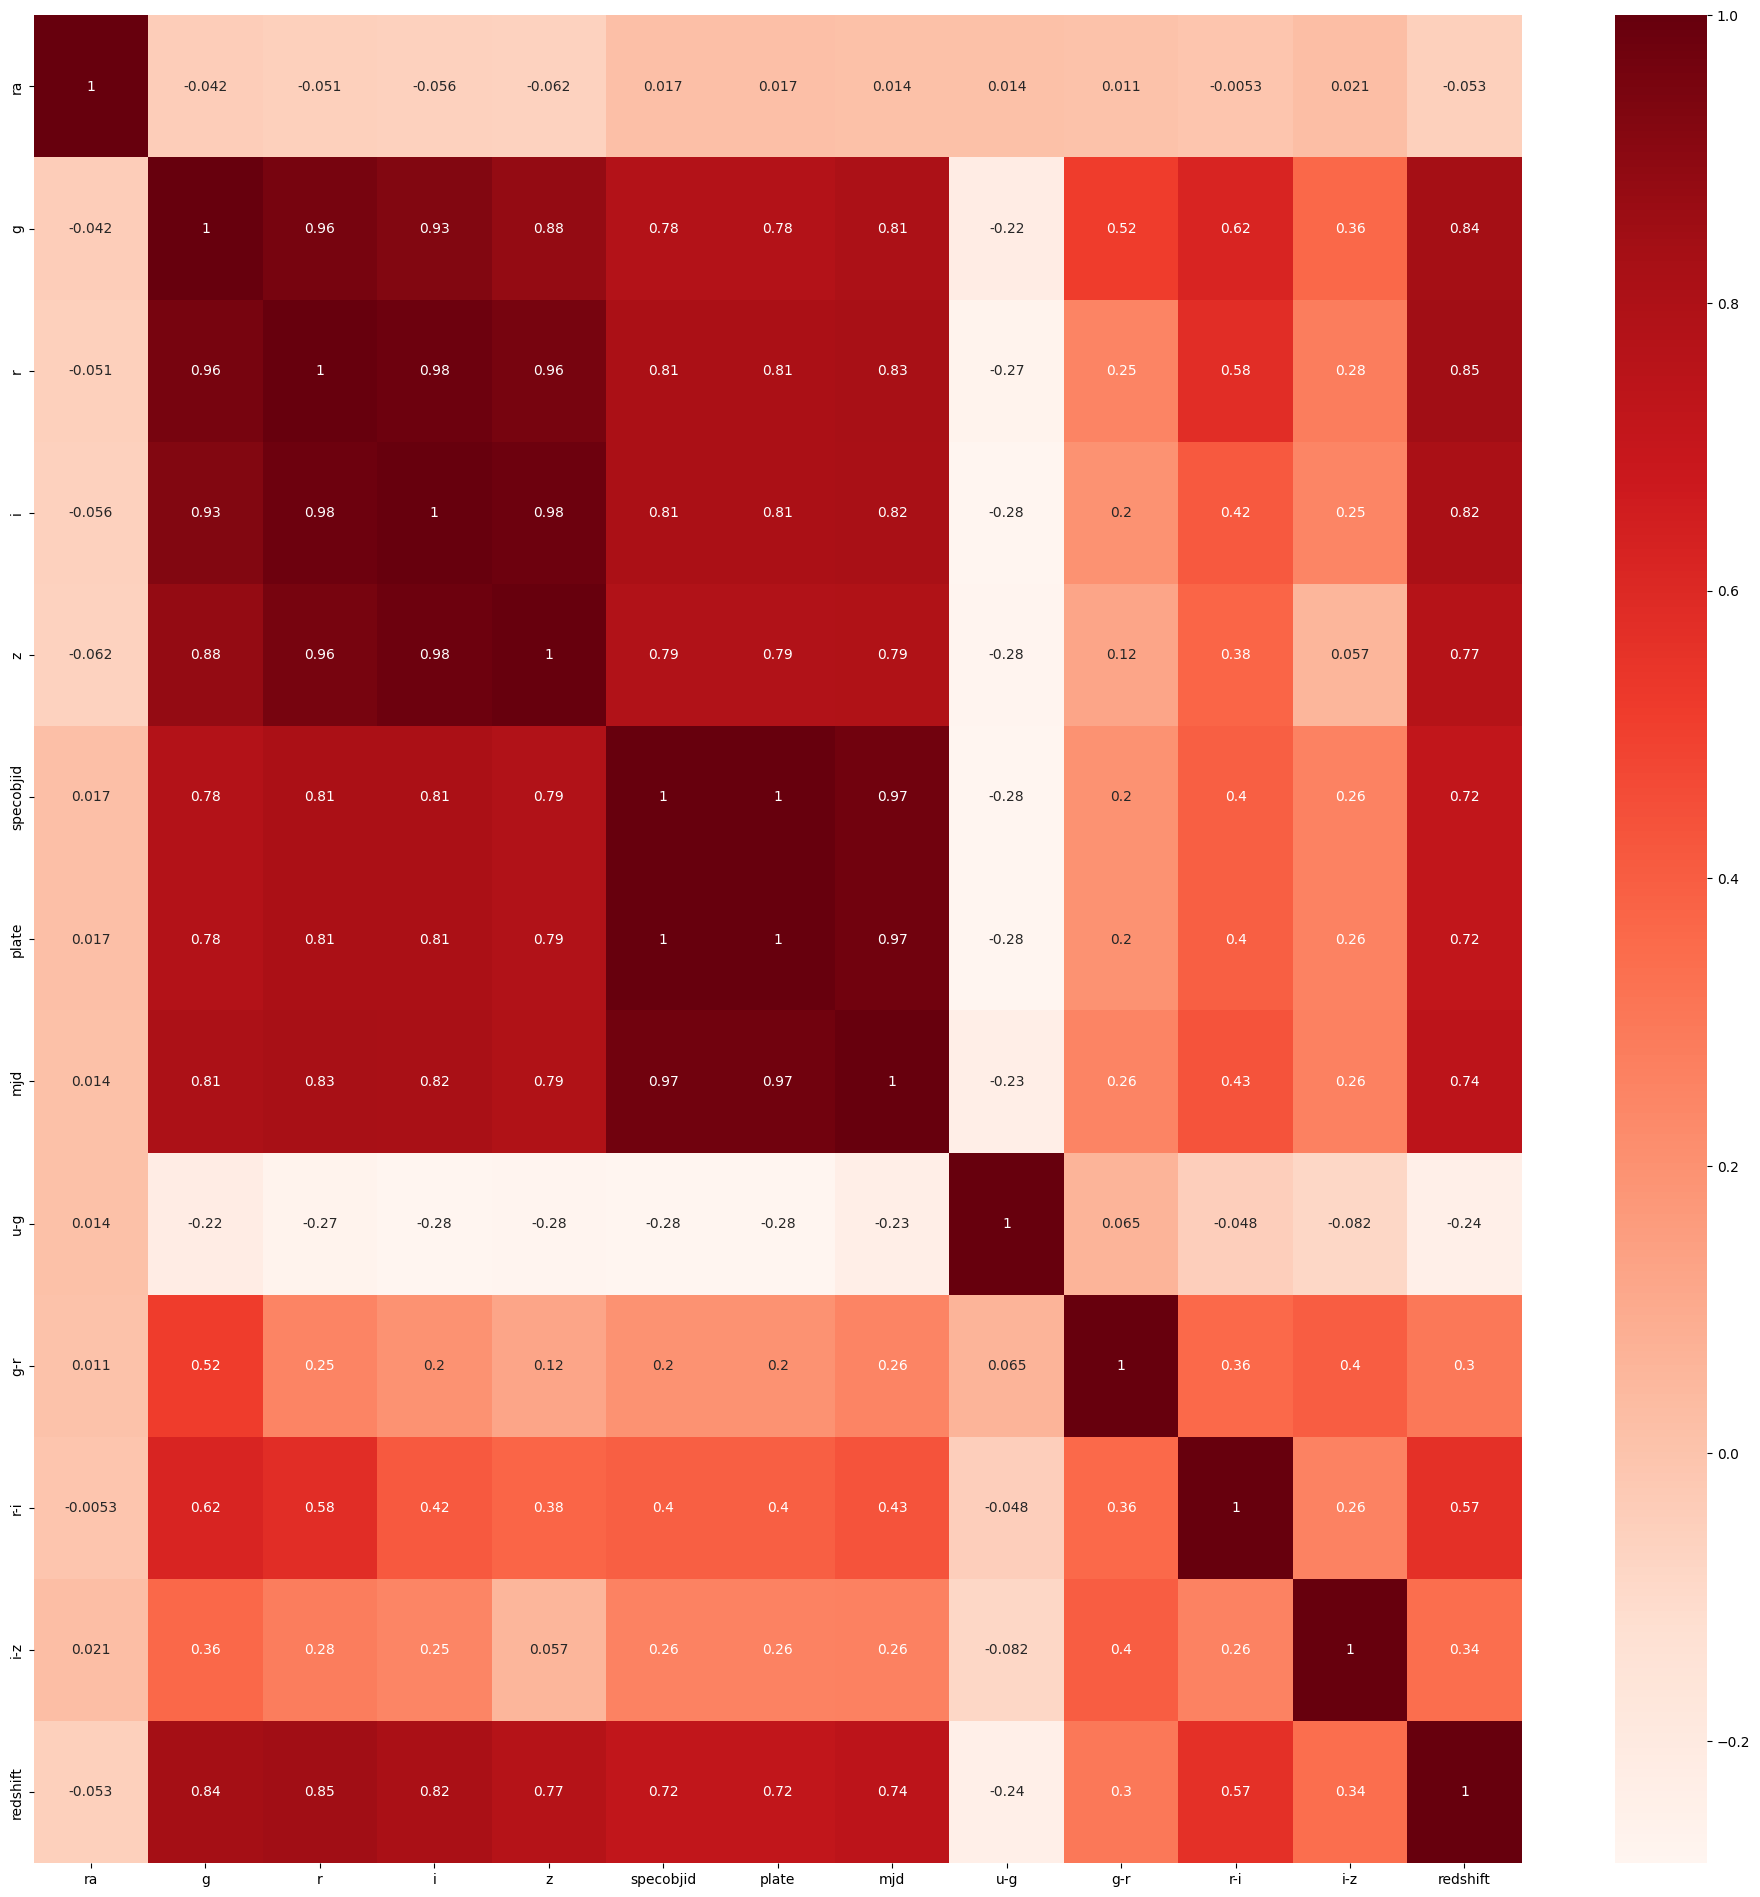

In [ ]:
# Compute the correlation between each of the numeric parameters as well as the
# target attribute
cor_fe = X_fe.join(y).corr()

# use seaborn to do the plot
fig, ax = plt.subplots(1,1, figsize=(24,24))
sns.heatmap(cor_fe, annot=True, cmap=plt.cm.Reds, ax=ax)
plt.show()

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

In the cell below, choose some features that you'd like to use for our ML model based on all of the above efforts.

In [ ]:
X = X_fe # here I select the features I like and get rid of non astro variables
y = galaxy_df['redshift'] # we want unscaled reshifts to be predicted

In [ ]:
#X = X[ ['g','r','i','z','u-g','g-r','r-i','i-z'] ]

## 4. KNN regression

KNN regression works in a similar way to the KNN classifier model that we explored last time.

The key difference is in how the neighbours contribute to the final output.
For a classifier each neighbour has a class which is votes for and the majority vote wins and is set as the output.
For a regressor, each neighbour has a value that it contributes, and the output is the (possibly weighted) average of all these values.

![knn-regression](https://files.realpython.com/media/knn_06_MLclassificationregression.6029d11323aa.png)

By now you should know what we are going to do:
- split the data into test/train sets
- set a bunch of parameters for tuning
- select the best beforming parameters for use

The only difference this time is that we'll be using the `KNeighborsRegressor` model since we want a continuous output.

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Create a test/train split from our `X_fe` data.


In [ ]:
# Split our data into a test/train set
# We use the training set to build our model
# We use the test set to measure the performance of our model
# Metric cannot be accuracy because we are nota labeling an object (Ture False)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    test_size=0.25, # use a test size of 25%
                                                                    random_state=4) # this random state ensures that we get the same subset each time we call this cell

We can do our gridsearch as before however we can no longer use 'accuracy' as a metrics, since we don't have categorical data.

Instead we need to use a different scoring metric.

For now let's use the $R^2$ metric since it's easy do understand.

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Perform a gridsearch with cross validation using the `R2` metric for scoring.



In [ ]:
# Create a dictionary of all the parameters we'll be iterating over
parameters = {'weights': ('uniform','distance'), # this should be the different weighting schemes
              'n_neighbors':[1,4,10,11,19,20,21,40,50]} # this should be a list of the nearest neigbhours
# make a classifier object
estimator = KNeighborsRegressor() #This is not KNN classifier
# create a GridSearchCV object to do the training with cross validation
gscv = model_selection.GridSearchCV(estimator=estimator,
                                    param_grid=parameters,
                                    scoring='r2')
# now train our model
knn = gscv.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
print(knn.best_params_, knn.best_score_)

{'n_neighbors': 20, 'weights': 'distance'} 0.7812679182186393


Review the detailed CV report

In [ ]:
print("n_neighbors |  weights |  R2 +/- std")
for i in range(len(knn.cv_results_['params'])):
  print(f"{knn.cv_results_['params'][i]['n_neighbors']:4d}   ", end='')
  print(f"{knn.cv_results_['params'][i]['weights']:>15s}     ", end='')
  print(f"{knn.cv_results_['mean_test_score'][i]: 5.3f}  +/- ", end='')
  print(f"{knn.cv_results_['std_test_score'][i]:5.3f}")

n_neighbors |  weights |  R2 +/- std
   1           uniform      0.660  +/- 0.064
   1          distance      0.660  +/- 0.064
   4           uniform      0.756  +/- 0.031
   4          distance      0.758  +/- 0.031
  10           uniform      0.777  +/- 0.029
  10          distance      0.780  +/- 0.029
  11           uniform      0.778  +/- 0.029
  11          distance      0.781  +/- 0.029
  19           uniform      0.777  +/- 0.026
  19          distance      0.781  +/- 0.027
  20           uniform      0.777  +/- 0.026
  20          distance      0.781  +/- 0.026
  21           uniform      0.776  +/- 0.026
  21          distance      0.781  +/- 0.026
  40           uniform      0.768  +/- 0.023
  40          distance      0.775  +/- 0.023
  50           uniform      0.764  +/- 0.022
  50          distance      0.773  +/- 0.022


![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Retrain our KNN model using the best parameters and recompute the $R^2$ metric. Compare the new score to our expecations from above.

In [ ]:
# use the best n_neighbors and weights
knn = KNeighborsRegressor(n_neighbors=20, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
print(f'R^2 = {r2}')

R^2 = 0.7780052868540345


Unlike a classificaiton task we don't have true/false positive/negative results.
Instead we have results which are different amounts of close to expectations, so we have different metrics for our models.

The $R^2$ is the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), while the mean square error (MSE) is, as the name suggests, the mean of the square of all the differences between the test and predicted data.

In [ ]:
print(f"R^2 = {metrics.r2_score(y_test, knn_y_pred):5.3f}")
print(f"MSE = {metrics.mean_squared_error(y_test, knn_y_pred):5.3f}")

R^2 = 0.778
MSE = 0.018


Since our predicted and test sets are dataframes we can `.describe()` the difference between them for a short summary of results.

In [ ]:
deltas = pd.DataFrame()
deltas['y-knn_y'] = y_test-knn_y_pred
deltas.describe()

,y-knn_y
count,2500.000000
mean,0.001548
std,0.135817
min,-0.911979
25%,-0.038158
50%,-0.002637
75%,0.040647
max,1.437729


Visually we can view our results in a scatter plot of test vs predicted redshift values.

Text(0.5, 1.0, 'KNN redshift estimation')

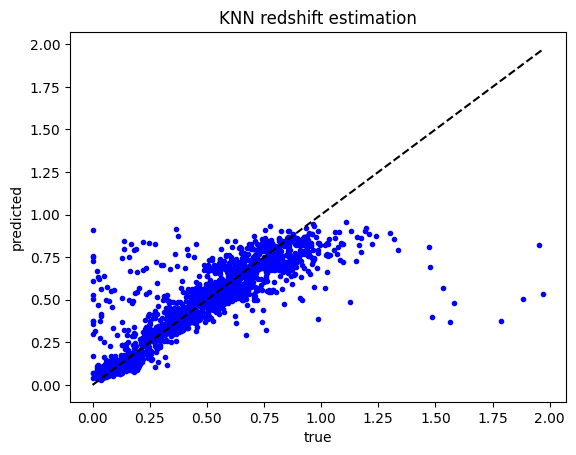

In [ ]:
mx = max(y_test.max(), knn_y_pred.max())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test,knn_y_pred, 'b.')
ax.plot([0,mx], [0, mx], 'k--')
ax.set_xlabel("true")
ax.set_ylabel("predicted")
ax.set_title("KNN redshift estimation")

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)
In the above plot, you should see that your ML model has done a fairly good job of estimating the redshift for the vast majority of galaxies.
The variance is less than 0.1.
However, the predictor doesn't seem to want to predict redshifts higher than about 0.5, even though there are some $z~1$ galaxies in our sample.

Why might this be the case?

## 5. Linear regression


Linear regression is a ML model that doesn't rely on memorizing the data.
Instead it will learn relationships between the features and the target and store those relationships.

Linear regression is a fancy name for a line of best fit.

The 2d equivalent is finding the best values for $m$ and $c$ such that: $y = mx +c$
![lr](https://astrobites.org/wp-content/uploads/2011/07/screen-shot-2011-07-25-at-10-19-29-pm.png)

With more features the equation becomes:

$$ F(\bar X) = \Sigma_i (w_i\times x_i) + c$$

Where the $w_i$ are the 'gradients' and $c$ is a constant.

There is an analytical solution to this problem which means that the training process for a linear regression model is fast to compute, and there are no hyper-parameters that need to be optimised over.

However it should be noted that the linear regression model assumes linear relationships between each of the features and the target.
Linear regression deals with information free features by assigning them low weights (or cancelling them out!), and is relatively immune to data scale.

❗ Linear regression will always give a result, but it may not be valid.

![xkcd-dogman](https://www.explainxkcd.com/wiki/images/9/91/linear_regression.png)

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Fit a linear regression model to our data and predict some redshifts

In [ ]:
# no need for a grid search as there are no hyper-parameters to tune
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

For a little fun, let's have a look at the euqation of best fit that was generated by our model.

In [ ]:
print("redshift = ",end='')
for feature, coef in zip(X_fe.columns, lr.coef_):
  print(f"{coef:+5.3f}*{feature} ", end='')
print(f"{lr.intercept_:+5.3f}")

redshift = -0.034*ra +0.571*g +1.181*r +0.116*i -0.394*z -219.591*specobjid +219.595*plate +0.126*mjd -0.076*u-g -0.613*g-r +0.914*r-i +0.642*i-z -0.732


![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

What does it mean for a feature to have a high or low weight in the above equation?

If we were using un-scaled data would you have a different answer?

A. We can use our own raw unscaled data here

Look at the $R^2$ and MSE metric, as well as the redshift residuals and decide if our linear regression model is better, worse, or comparable to the KNN model we created earlier.

In [ ]:
print(f"R^2 = {metrics.r2_score(y_test, lr_y_pred):5.3f}")
print(f"MSE = {metrics.mean_squared_error(y_test, lr_y_pred):5.3f}")

R^2 = 0.748
MSE = 0.021


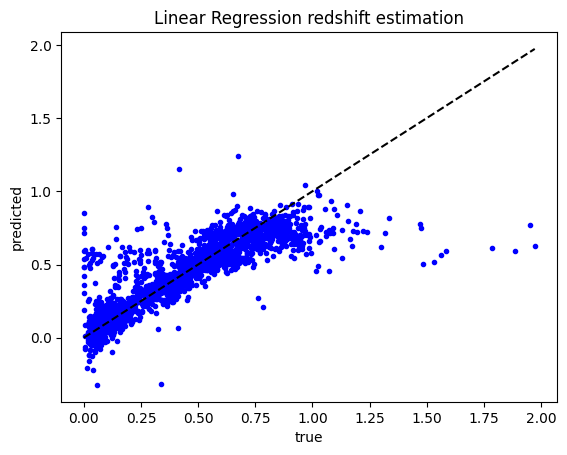

In [ ]:
mx = max(y_test.max(), lr_y_pred.max())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test,lr_y_pred, 'b.')
ax.plot([0,mx], [0, mx], 'k--')
ax.set_xlabel("true")
ax.set_ylabel("predicted")
ax.set_title("Linear Regression redshift estimation")
plt.show()

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

What are some features of the above plot that are different from the KNN version of the plot?

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Add a new column to our `deltas` data frame for the linear regression results and compare them to the knn results.

In [ ]:
deltas['y-lr_y'] = y_test-lr_y_pred
deltas.describe()

,y-knn_y,y-lr_y
count,2500.000000,2500.000000
mean,0.001548,0.002456
std,0.135817,0.144643
min,-0.911979,-0.850501
25%,-0.038158,-0.051298
50%,-0.002637,-0.004632
75%,0.040647,0.053878
max,1.437729,1.348844


## 6. Principle Component Analysis (PCA)

So far we have been spending time figuring out which features to use and even creating new features.
The new features that we created were linear combinations of other features.
We created only pair-wise and equally weighted combinations, but we could have created combinations of features that were not equally weighted, and also combinations that involved more than two features.
We could go down the path of trying multiple different combinations of features chaning the number of features included and the relative weights, but it would be a fairly time and compute intensive process.

If we restrict ourselves to linear combinations of features, and assume that the variance of a (scaled) feature is a measure of the information content, then we can use principle component analysis (PCA) to generate these combinaitons of features for us.

PCA works as follows:
1. Looking in the n-dimensional parameter space spanned by our features and ask "what is the direction corresponding to the largest amount of variance"
1. Label this direction as PC1 (principle component 1)
1. project all our data onto this component and then subtract it to form an (n-1)-dimenstional parameter space
1. If we have more than 1 dimension left GOTO (1), else this last dimension is our final component

![pca](https://i0.wp.com/statisticsbyjim.com/wp-content/uploads/2023/01/PCA_original.png?w=596&ssl=1)

PCA is therfore a way of rotating and scaling our data onto a new set of features such that PC1 is the most informative and PCN is the least.

If we have this ordering of components then we can choose our k-best features just by looking features PC1...PCk.
Thus we can think of PCA as a feature selection tool, but in reality is a dimensionality reduction tool.

Begin by forming as many principle components as we have columns in our data.

In [ ]:
# Start with all our scaled data, but no the redshift
data = numerics.drop(columns=['redshift'])
pca = PCA(n_components=len(data.columns))
pca.fit(data)

PCA(n_components=19)

We can nthen ask, for each of our new PCA features, how much variance is explained by that component.

In [ ]:
print(pca.explained_variance_) # To realize the unnecessary data

[3.15706440e-01 1.11479299e-01 9.32008639e-02 5.96198496e-02
 4.35498410e-02 3.35982628e-02 2.67399618e-02 2.03139354e-02
 7.08443754e-03 1.93497567e-03 1.79913740e-03 2.47003640e-04
 1.34176063e-04 2.82364771e-23 1.32117900e-28 1.25493817e-36
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


Additionally, we can see how the principle components are being created.

In [ ]:
for i, c in enumerate(pca.components_[:3]):
  print(f"PC{i+1} = ")
  for feature, weight in zip(data.columns, c):
    print(f"\t{feature:9s}* {weight:+5.3f}")

To choose how many components we should use, we can then plot the total explained variance as a function of the number of features used.
We can then see how many features it would take to exaplin some pre-determined cuttoff of variance (say $95\%$).

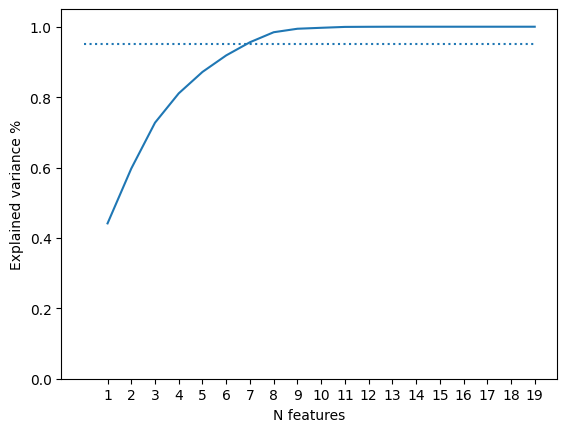

7 features are required to explain 95.0% of the variance.


In [ ]:
# Create a curve of cumulative explained variance
total_var = np.array([np.sum(pca.explained_variance_[:i+1]) for i in range(pca.n_components_)])
total_var /= total_var[-1]

# how much variance are we looking to explain?
target_variance = 0.95

# setup our plot
fig, ax = plt.subplots(1,1)
ax.plot(range(1,len(total_var)+1), total_var)
ax.hlines(target_variance, 0, pca.n_components_, ls=':')
ax.set_xlabel("N features")
ax.set_ylabel("Explained variance %")
ax.set_xticks(range(1,len(total_var)+1))
ax.set_ylim([0,1.05])
plt.show()

# determine how many features we need to reach the target variance
min_features = np.where(total_var>target_variance)[0][0] +1
print(f"{min_features} features are required to explain {target_variance*100}% of the variance.")

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Transform our data and select just the top k features for our modelling.

In [ ]:
X_pca = pca.transform(data)[:,:3]
X_pca.shape

(10000, 3)

![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Create test/train sets as before and train our linear model

In [ ]:
# Split our data into a test/train set
# We use the training set to build our model
# We use the test set to measure the performance of our model
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_pca, y,
                                                                    test_size=0.25, # use a test size of 25%
                                                                    random_state=4) # this random state ensures that we get the same subset each time we call this cell

In [ ]:
# make a linear regression model, train it, and do prediction on the PCA data
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

In [ ]:
print(f"R^2 = {metrics.r2_score(y_test, lr_y_pred):5.3f}")
print(f"MSE = {metrics.mean_squared_error(y_test, lr_y_pred):5.3f}")

R^2 = 0.631
MSE = 0.031


Text(0.5, 1.0, 'redshift estimation')

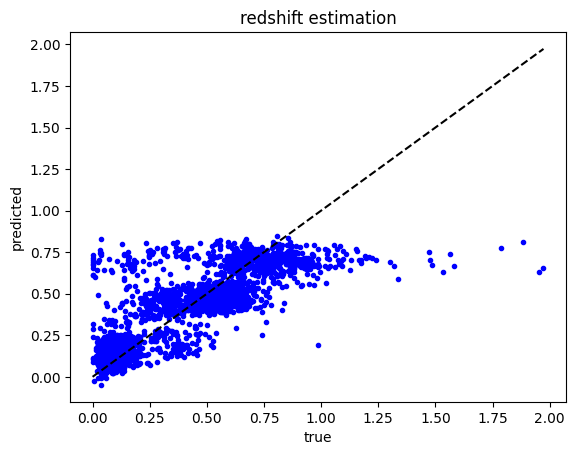

In [ ]:
mx = max(y_test.max(), lr_y_pred.max())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test,lr_y_pred, 'b.')
ax.plot([0,mx], [0, mx], 'k--')
ax.set_xlabel("true")
ax.set_ylabel("predicted")
ax.set_title("redshift estimation")

In [ ]:
# add a nother column to our deltas data frame
deltas['y-lr_pca_y'] = y_test-lr_y_pred
deltas.describe()

,y-knn_y,y-lr_y,y-lr_pca_y
count,2500.000000,2500.000000,2500.000000
mean,0.001548,0.002456,0.004975
std,0.135817,0.144643,0.175074
min,-0.911979,-0.850501,-0.793955
25%,-0.038158,-0.051298,-0.078427
50%,-0.002637,-0.004632,0.007696
75%,0.040647,0.053878,0.092295
max,1.437729,1.348844,1.318979


![Challenge](https://cdn.icon-icons.com/icons2/2110/PNG/64/challenge_icon_131034.png)

Experiment with different number of PCA features and see how few you can use whilst still obtaining a useful redshift prediction.

## Explore more
If you have time before the next deep dive try the following:
- **Data Cleaning**: Apply alternative [scaling](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) models to features that don't have a uniform distribution
- **Feature Selection**: Remove all the 'non astro' features from the dataset and see if this improves your model predictions
- **Regression**: Try using an alternative regression method such as the [multi-layer perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)